In [ ]:
import itertools
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

dtype = torch.float
device = torch.device("cpu")

## Defining resources
We define some relevant functions and costant variables to use in this notebook.

In [ ]:
BATCH_SIZE = 124
LEARNING_RATE = 0.001
MOMENTUM = 0
DAMPENING = 0
NESTEROV = False
L2 = 0.0
EPOCHS = 50

In [ ]:
#function to compute the accuracy
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
#define a neural network
class BinaryClassification(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(n_input, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, 1) 
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        #x = self.layer_out(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x

In [ ]:
#function to define the train phase
def TrainPhase(epochs, model, aggregated_losses, aggregated_accuracy, data_train, loss, optimizer):
    model.train()
    i = epochs
    for X_batch, y_batch in data_train:
        optimizer.zero_grad()
       
        y_pred = model(X_batch)
        
        single_loss = loss(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
            
        
        single_loss.backward()
        optimizer.step()
        
        #epoch_loss += single_loss.item()
        #epoch_acc += acc.item()
        
    #aggregated_losses.append(epoch_loss/len(data_train))
    #aggregated_accuracy.append((epoch_acc/len(data_train))/100)
    #print(f'TRAIN - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_train):.5f} | Acc: {epoch_acc/len(data_train):.3f}')

    aggregated_losses.append(single_loss.item())
    aggregated_accuracy.append(acc/100)
    print(f'TRAIN - Epoch {i+0:03}: | Loss: {single_loss.item():.5f} | Acc: {acc:.3f}')
    
    return model, aggregated_losses, aggregated_accuracy

In [ ]:
#function to define the evaluate phase
def Evaluate(epochs, model, aggregated_losses, aggregated_accuracy, data_test, loss_f):
    
    i = epochs
    #for i in range(1, epochs+1):
    y_pred_list = []
    model.eval()
        
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for X_batch, y_batch in data_test:
            y_test_pred = model(X_batch)
            loss = loss_f(y_test_pred, y_batch)
            acc = binary_acc(y_test_pred, y_batch)
                
            #epoch_loss += loss.item()
            #epoch_acc += acc.item()

            #y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.detach().numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    #flattens the lists in sequence
    ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

    #aggregated_losses.append(epoch_loss/len(data_test))
    #aggregated_accuracy.append((epoch_acc/len(data_test))/100)
    #print(f'TEST - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')
    
    aggregated_losses.append(loss.item())
    aggregated_accuracy.append(acc/100)
    print(f'TEST - Epoch {i+0:03}: | Loss: {loss.item():.5f} | Acc: {acc:.3f}')
    
    return ytest_pred, aggregated_losses, aggregated_accuracy
    

## Loading MONK-1 dataset
Now we load the first MONK dataset.

In [ ]:
#read train dataset
df_monk1_train = pd.read_csv('./data/MONK/monks-1.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk1_test = pd.read_csv('./data/MONK/monks-1.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk1_test.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1


In [ ]:
df_monk1_train

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1
...,...,...,...,...,...,...,...
119,1,3,3,2,1,4,2
120,1,3,3,2,3,1,2
121,1,3,3,2,3,2,2
122,1,3,3,2,3,3,2


<AxesSubplot:ylabel='class'>

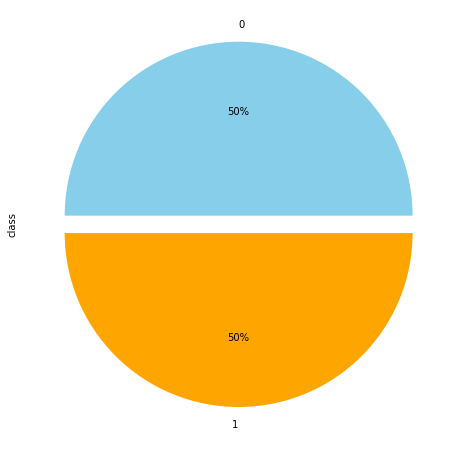

In [ ]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk1_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

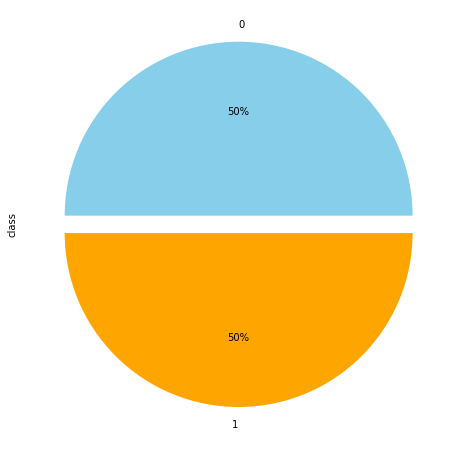

In [ ]:
#plot class distribution in test data
df_monk1_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [ ]:
#prepare train and test data
target_train = df_monk1_train.pop('class')
target_test = df_monk1_test.pop('class')
#X_train = df_monk1_train
#y_train = target_train
X_test = df_monk1_test
y_test = target_test

In [ ]:
#prepare validation set
X_train, X_validation, y_train, y_validation = train_test_split(df_monk1_train, target_train, stratify=target_train, test_size=0.30)

In [ ]:
#scaler = preprocessing.MinMaxScaler()
#x_train = scaler.fit_transform(X_train.values)
#x_test =  scaler.fit_transform(X_test.values)

In [ ]:
#create tensor for train and test data 
X_train = X_train.values #returns a ndarray
X_test = X_test.values
X_validation = X_validation.values

x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xval_tensor =  torch.from_numpy(X_validation).float()
yval_tensor =  torch.from_numpy(y_validation.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_test).float()
ytest_tensor =  torch.from_numpy(y_test.values.ravel()).float()

In [ ]:
#prepare dataloader for training
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

In [ ]:
#prepare dataloader for validation 
yval_tensor = yval_tensor.unsqueeze(1)
val_ds = TensorDataset(xval_tensor, yval_tensor)
val_loader = DataLoader(val_ds, batch_size=64)

In [ ]:
#prepare dataloader for evaluating 
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=64)

## Training and evaluate
In this section, we train the network and control the results.

In [ ]:
#define the model
model = BinaryClassification(X_train.shape[1], 300, 100)

In [ ]:
#define the loss function 
loss_function = nn.BCELoss()
#define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=L2, dampening=DAMPENING, nesterov=NESTEROV)
#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

After that defined the model, we start the training and evaluating process with prefixed number of epochs. Each epoch, we save the results on lists for plotting the train and evaluate trends.  

In [ ]:
#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 
  # Early stopping
  last_loss = 1
  patience = 2
  trigger_times = 0

  model, losses_train, accuracies_train = TrainPhase(epoch, model, losses_train, accuracies_train, train_loader, loss_function, optimizer)
  #y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, val_loader, loss_function)

  # Early stopping
  if losses_test[epoch] > last_loss:
      trigger_times += 1

      if trigger_times >= patience:
          print('Early stopping!\nStart to test process.')
          break
  else:
      trigger_times = 0
  
  print("##############################")


TRAIN - Epoch 001: | Loss: 0.70656 | Acc: 60.000
TEST - Epoch 001: | Loss: 0.75270 | Acc: 0.000
##############################
TRAIN - Epoch 002: | Loss: 0.66654 | Acc: 65.000
TEST - Epoch 002: | Loss: 0.74833 | Acc: 0.000
##############################
TRAIN - Epoch 003: | Loss: 0.66455 | Acc: 66.000
TEST - Epoch 003: | Loss: 0.74394 | Acc: 0.000
##############################
TRAIN - Epoch 004: | Loss: 0.66503 | Acc: 63.000
TEST - Epoch 004: | Loss: 0.73895 | Acc: 6.000
##############################
TRAIN - Epoch 005: | Loss: 0.65501 | Acc: 62.000
TEST - Epoch 005: | Loss: 0.73362 | Acc: 15.000
##############################
TRAIN - Epoch 006: | Loss: 0.66285 | Acc: 65.000
TEST - Epoch 006: | Loss: 0.72787 | Acc: 25.000
##############################
TRAIN - Epoch 007: | Loss: 0.65381 | Acc: 64.000
TEST - Epoch 007: | Loss: 0.72170 | Acc: 29.000
##############################
TRAIN - Epoch 008: | Loss: 0.64659 | Acc: 67.000
TEST - Epoch 008: | Loss: 0.71512 | Acc: 38.000
###########

In [ ]:
#control the accuracy between true and predict values on test data
y_true_test = y_test.values.ravel()
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.66      0.81      0.72       216
           1       0.75      0.57      0.65       216

    accuracy                           0.69       432
   macro avg       0.70      0.69      0.69       432
weighted avg       0.70      0.69      0.69       432



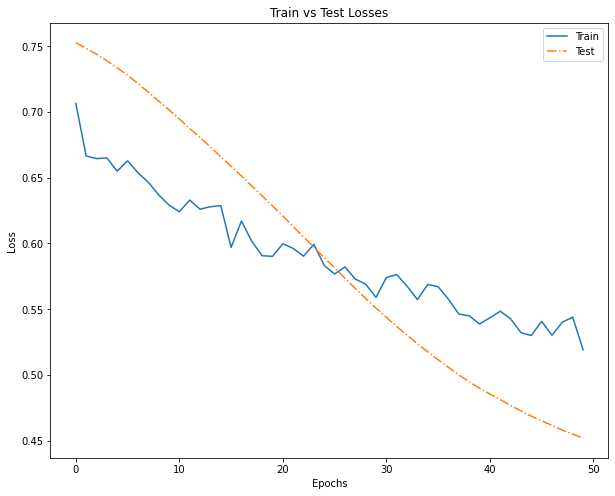

In [ ]:
#create a loss plot
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

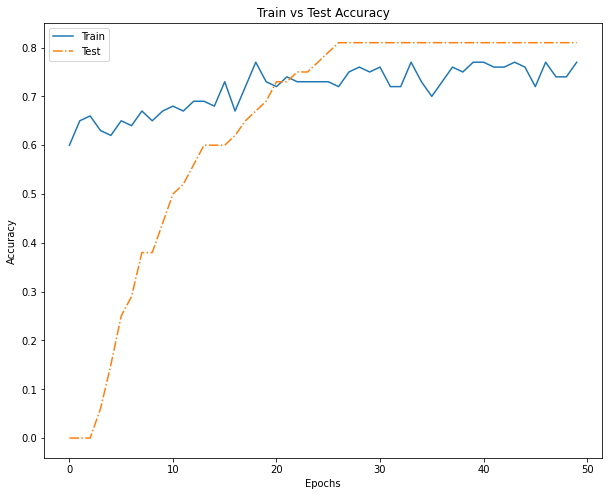

In [ ]:
#create an accuracy plot
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

### One hot encoding

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train)
X_train = enc_train.transform(X_train).toarray()
print(X_train.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test)
X_test = enc_test.transform(X_test).toarray()
print(X_test.shape)

(124, 17)
(432, 17)


### Loading MONK-2 dataset

In [ ]:
df_monk2_train = pd.read_csv('./data/MONK/monks-2.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_train.drop(labels='id', axis=1, inplace=True)

df_monk2_test = pd.read_csv('./data/MONK/monks-2.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk2_test.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,1,1
1,0,1,1,1,1,1,2
2,0,1,1,1,1,2,1
3,0,1,1,1,1,2,2
4,0,1,1,1,1,3,1


In [ ]:
df_monk2_train

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1
...,...,...,...,...,...,...,...
164,0,3,3,2,2,3,1
165,0,3,3,2,2,3,2
166,1,3,3,2,3,1,1
167,0,3,3,2,3,2,1


<AxesSubplot:ylabel='class'>

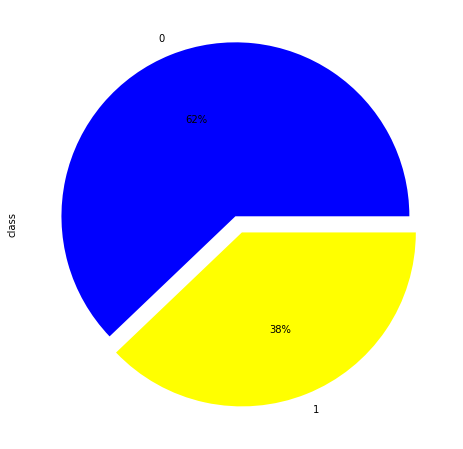

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk2_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

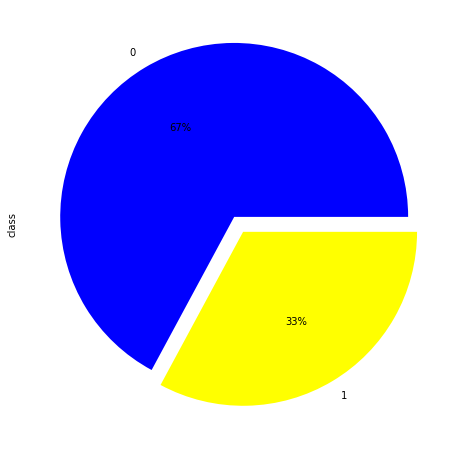

In [ ]:
df_monk2_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

In [ ]:
target_train = df_monk2_train.pop('class')
target_test = df_monk2_test.pop('class')
X_train = df_monk2_train
y_train = target_train
X_test = df_monk2_test
y_test = target_test

In [ ]:
X_train = X_train.values #returns a ndarray
X_test = X_test.values
x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_test).float()
ytest_tensor =  torch.from_numpy(y_test.values.ravel()).float()

In [ ]:
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

In [ ]:
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=64)

In [ ]:
model = BinaryClassification(X_train.shape[1], 300, 100)

In [ ]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

for epoch in range(1,EPOCHS+1): 
  model, losses_train, accuracies_train = TrainPhase(epoch, model, losses_train, accuracies_train, train_loader, loss_function, optimizer)
  y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  print("##############################")

TRAIN - Epoch 001: | Loss: 0.73459 | Acc: 56.000
TEST - Epoch 001: | Loss: 0.71849 | Acc: 35.000
##############################
TRAIN - Epoch 002: | Loss: 0.59108 | Acc: 76.000
TEST - Epoch 002: | Loss: 0.67878 | Acc: 65.000
##############################
TRAIN - Epoch 003: | Loss: 0.50213 | Acc: 87.000
TEST - Epoch 003: | Loss: 0.65158 | Acc: 62.000
##############################
TRAIN - Epoch 004: | Loss: 0.44402 | Acc: 84.000
TEST - Epoch 004: | Loss: 0.63545 | Acc: 56.000
##############################
TRAIN - Epoch 005: | Loss: 0.39614 | Acc: 84.000
TEST - Epoch 005: | Loss: 0.62374 | Acc: 56.000
##############################
TRAIN - Epoch 006: | Loss: 0.35793 | Acc: 89.000
TEST - Epoch 006: | Loss: 0.61236 | Acc: 56.000
##############################
TRAIN - Epoch 007: | Loss: 0.34947 | Acc: 87.000
TEST - Epoch 007: | Loss: 0.60042 | Acc: 60.000
##############################
TRAIN - Epoch 008: | Loss: 0.32351 | Acc: 89.000
TEST - Epoch 008: | Loss: 0.58748 | Acc: 65.000
#######

In [ ]:
y_true_test = y_test.values.ravel()
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.74      0.79       290
           1       0.59      0.75      0.66       142

    accuracy                           0.74       432
   macro avg       0.72      0.74      0.73       432
weighted avg       0.77      0.74      0.75       432



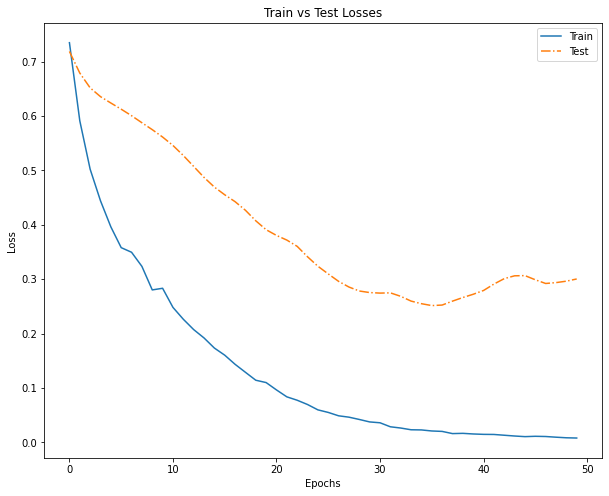

In [ ]:
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

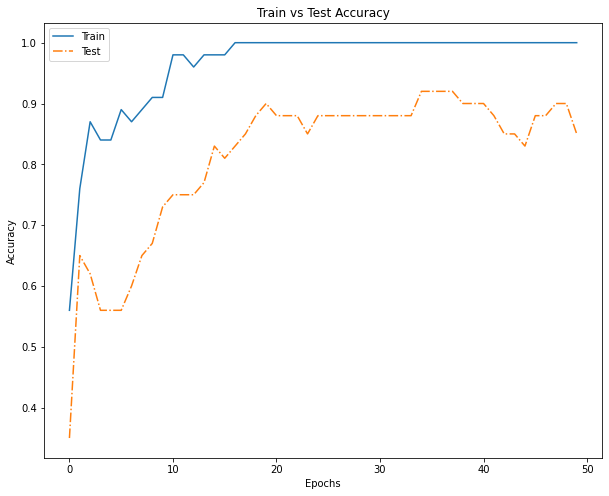

In [ ]:
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

## Loading MONK-3 dataset

In [ ]:
#read train dataset
df_monk3_train = pd.read_csv('./data/MONK/monks-3.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk3_test = pd.read_csv('./data/MONK/monks-3.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk3_train.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


In [ ]:
df_monk3_test.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1


<AxesSubplot:ylabel='class'>

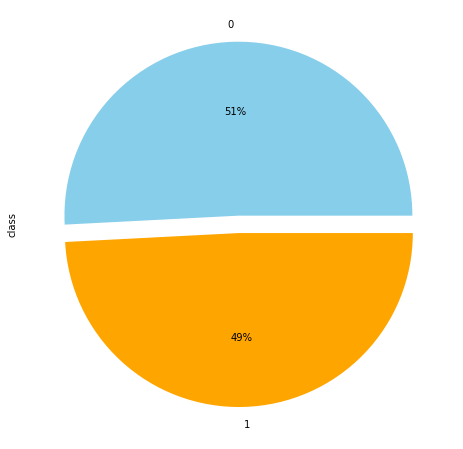

In [ ]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk3_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

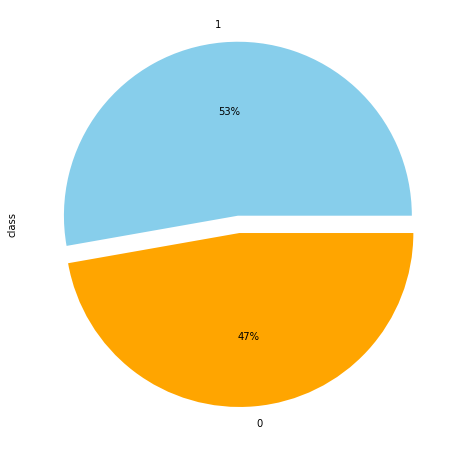

In [ ]:
#plot class distribution in test data
df_monk3_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [ ]:
#prepare train and test data
target_train = df_monk3_train.pop('class')
target_test = df_monk3_test.pop('class')
X_train = df_monk3_train
y_train = target_train
X_test = df_monk3_test
y_test = target_test

In [ ]:
#create tensor for train and test data 
X_train = X_train.values #returns a ndarray
X_test = X_test.values
x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_test).float()
ytest_tensor =  torch.from_numpy(y_test.values.ravel()).float()

In [ ]:
#prepare dataloader for training
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

In [ ]:
#prepare dataloader for evaluating 
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=64)

In [ ]:
#define the model
model = BinaryClassification(X_train.shape[1], 300, 100)

In [ ]:
#define the loss function 
loss_function = nn.BCELoss()
#define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=L2, dampening=DAMPENING, nesterov=NESTEROV)

In [ ]:
#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 
  model, losses_train, accuracies_train = TrainPhase(epoch, model, losses_train, accuracies_train, train_loader, loss_function, optimizer)
  y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  print("##############################")


TRAIN - Epoch 001: | Loss: 0.80436 | Acc: 40.000
TEST - Epoch 001: | Loss: 0.59282 | Acc: 92.000
##############################
TRAIN - Epoch 002: | Loss: 0.81670 | Acc: 39.000
TEST - Epoch 002: | Loss: 0.58817 | Acc: 92.000
##############################
TRAIN - Epoch 003: | Loss: 0.78846 | Acc: 43.000
TEST - Epoch 003: | Loss: 0.58372 | Acc: 92.000
##############################
TRAIN - Epoch 004: | Loss: 0.77582 | Acc: 48.000
TEST - Epoch 004: | Loss: 0.57961 | Acc: 92.000
##############################
TRAIN - Epoch 005: | Loss: 0.75225 | Acc: 45.000
TEST - Epoch 005: | Loss: 0.57571 | Acc: 92.000
##############################
TRAIN - Epoch 006: | Loss: 0.77244 | Acc: 46.000
TEST - Epoch 006: | Loss: 0.57183 | Acc: 92.000
##############################
TRAIN - Epoch 007: | Loss: 0.75396 | Acc: 45.000
TEST - Epoch 007: | Loss: 0.56809 | Acc: 92.000
##############################
TRAIN - Epoch 008: | Loss: 0.75093 | Acc: 48.000
TEST - Epoch 008: | Loss: 0.56450 | Acc: 92.000
#######

In [ ]:
#control the accuracy between true and predict values on test data
y_true_test = y_test.values.ravel()
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       204
           1       0.83      0.66      0.74       228

    accuracy                           0.75       432
   macro avg       0.76      0.76      0.75       432
weighted avg       0.76      0.75      0.75       432



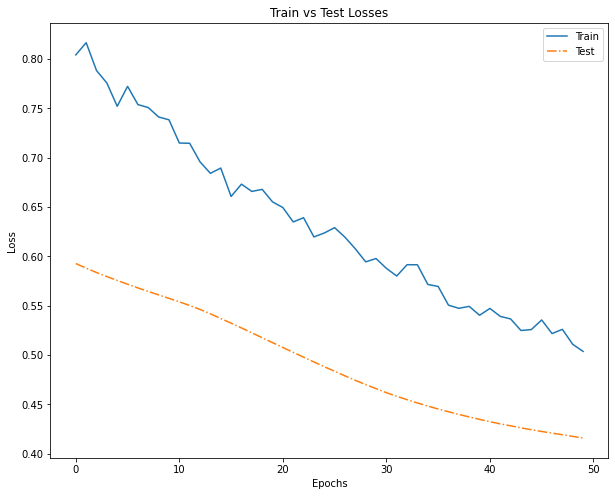

In [ ]:
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

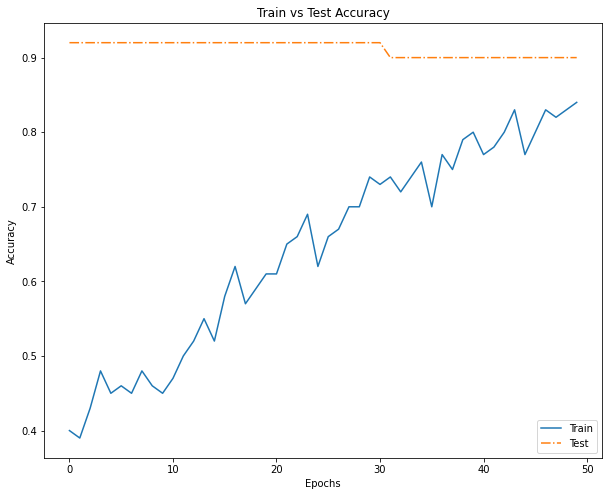

In [ ]:
#create an accuracy plot
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>